In [15]:
import yfinance as yf
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import altair as alt
alt.data_transformers.enable('data_server') # allows plotting more than 5000 rows of data

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing, ETSModel, seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet
from scripts.utils import *
from scripts.plotting import *
from itertools import product

import warnings
warnings.filterwarnings('ignore')

# Short term stock forecaster

In [2]:
def create_forecast_index(start, horizon=30, freq="M"):
    return pd.date_range(start + pd.tseries.frequencies.to_offset(freq), periods=horizon, freq=freq, name="Time")

def get_hist(ticker):
    """Get historical market data for stock ticker"""
    stock = yf.Ticker(ticker)
    # get historical market data
    hist = stock.history(period="max")
    hist = hist.resample('D').mean()
    return hist

In [47]:
stock = yf.Ticker(ticker)
ticker = 'SU'
hist = get_hist(ticker)
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15443 entries, 1980-03-17 to 2022-06-27
Freq: D
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          10661 non-null  float64
 1   High          10661 non-null  float64
 2   Low           10661 non-null  float64
 3   Close         10661 non-null  float64
 4   Volume        10661 non-null  float64
 5   Dividends     10661 non-null  float64
 6   Stock Splits  10661 non-null  float64
dtypes: float64(7)
memory usage: 965.2 KB


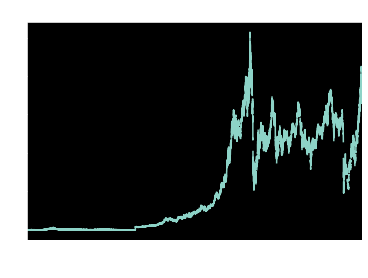

In [4]:
hist['Close'].plot()
plt.title(ticker);

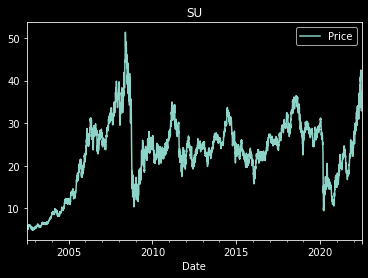

In [28]:
# input desired forecast window in years
period = 20
hist_impute = hist.interpolate(method="polynomial", order=2)
hist_impute.index.freq = 'D'
end_date = hist_impute.index[-1]
train_start = end_date - period*365*hist_impute.index.freq
hist_trim = pd.DataFrame({'Price': hist_impute.loc[train_start:end_date, 'Close'],
                         'Label': 'Data'})
hist_trim.plot()
plt.title(ticker)

train_df, valid_df = train_test_split(hist_trim, test_size=0.2, shuffle=False)
train_df['Label'] = 'Train'
valid_df['Label'] = 'Valid'

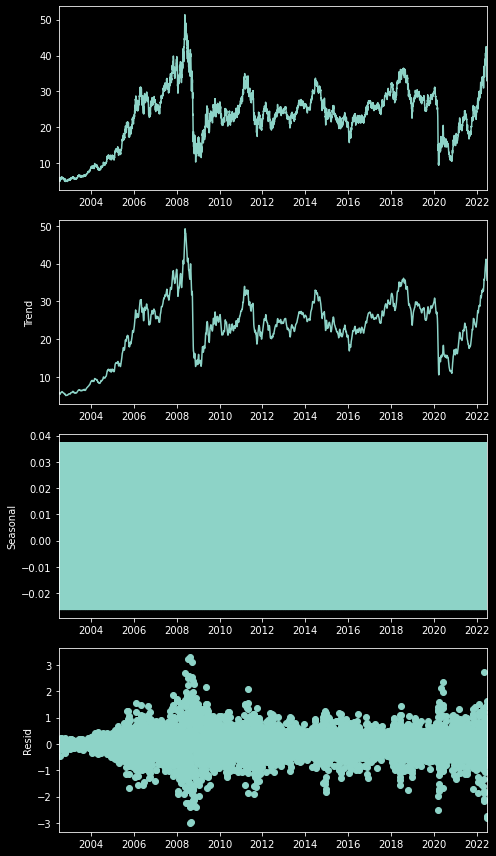

In [29]:
model = seasonal_decompose(hist_trim[["Price"]], model="additive", period=12)
with mpl.rc_context():  # this context manager help adjust the size of the plot
    mpl.rc("figure", figsize=(7, 12))
    model.plot()
    plt.tight_layout()

## Train model on training data, find optimum params

In [30]:
valid_index = create_forecast_index(train_df.index[-1], horizon=len(valid_df.index), freq="d")

In [31]:
# ARIMA
optimum_model = {"aic": np.inf}
for p, d, q in product(range(4), range(4), range(4)):
    model = ARIMA(train_df['Price'], order=(p, d, q)).fit()
    if model.aic < optimum_model["aic"]:
        optimum_model["aic"] = model.aic
        optimum_model["order"] = (p, d, q)
print(optimum_model)
arima_params = optimum_model['order']

{'aic': 6609.223928137061, 'order': (2, 1, 3)}


In [32]:
# ETS
optimum_model = {"aic": np.inf}

for e, t, s, d in product(['add', 'mul'], ['add', 'mul'], ['add', 'mul'], [True, False]):
    model = ETSModel(train_df['Price'], error=e, trend=t, seasonal=s, damped_trend=d).fit()
    if model.aic < optimum_model["aic"]:
        optimum_model["aic"] = model.aic
        optimum_model["order"] = (e, t, s, d)
print(optimum_model)
ets_params = optimum_model['order']

{'aic': 5762.671736271186, 'order': ('mul', 'add', 'mul', False)}


In [33]:
# Prophet
prophet_df = pd.DataFrame({"ds": train_df.index,
                           "y": train_df["Price"].to_numpy()}, index=None)
model_proph = Prophet(interval_width=0.95)
model_proph.fit(prophet_df);

INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


## Test models on validation set, return highest performing model

In [34]:
# Arima
model_arima = ARIMA(train_df['Price'], order=(arima_params[0], arima_params[1], arima_params[2])).fit()
forecast_arima = pd.DataFrame({"Price": model_arima.forecast(len(valid_index)),
                                "Label": "ARIMA"},
                               index=valid_index)

In [35]:
# ETS
model_ets = ETSModel(train_df['Price'], error=ets_params[0], trend=ets_params[1], seasonal=ets_params[2], damped_trend=ets_params[3]).fit()
forecast_ets = pd.DataFrame({"Price": model_ets.forecast(len(valid_index)),
                                "Label": "ETS"},
                               index=valid_index)


In [36]:
# Prophet
test_dates = model_proph.make_future_dataframe(periods=len(valid_df), freq="D", include_history=False)
forecasts_proph = model_proph.predict(test_dates)

prophet_forecast_valid = pd.DataFrame({"Price": forecasts_proph['yhat'].to_numpy(),
                                "Label": "Prophet"},
                               index=valid_index)

In [37]:
# check validation results
df = pd.concat((train_df, valid_df, forecast_arima, forecast_ets, prophet_forecast_valid))

alt.Chart(df.reset_index(), title=ticker).mark_line().encode(
    x=alt.X('index:T', title='Date'),
    y='Price:Q',
    color="Label",
    tooltip=['Price', 'index']
).properties(width=800, height=600)

alt.Chart(...)

In [43]:
# Check MAPE
forecasts = {'ets': forecast_ets, 'arima': forecast_arima, 'prophet': prophet_forecast_valid}

def MAPE(models):
    error = np.inf
    best_forecast = None
    label = None
    results = {}
    
    for label, model in forecasts.items():
        results[label] = mean_absolute_percentage_error(y_true=valid_df['Price'], y_pred=model['Price'])
        if results[label] < error:
            best_forecast = model
            error = results[label]
            best_label = label
    return best_forecast, error, best_label, results

best_fcast, error, best_label, results = MAPE(forecasts)
print(f"Best model: {best_label}, Error: {error:.2f}")
pd.DataFrame(results, index=['MAPE']).T

Best model: arima, Error: 0.56


,MAPE
ets,0.809017
arima,0.555517
prophet,0.697217


## Return forecast as plot and df

In [44]:
forecast_horizon = 365
forecast_index = create_forecast_index(hist_impute.index[-1], horizon=forecast_horizon, freq="d")

In [45]:
# if best_label == 'arima':
model = ARIMA(hist_trim['Price'], order=(arima_params[0], arima_params[1], arima_params[2])).fit()
arima_forecast = pd.DataFrame({"Price": model.forecast(len(forecast_index)),
                                "Label": "ARIMA"},
                               index=forecast_index)

# else:
model = ETSModel(hist_trim['Price'], error=ets_params[0], trend=ets_params[1], seasonal=ets_params[2], damped_trend=ets_params[3]).fit()
ets_forecast = pd.DataFrame({"Price": model.forecast(len(forecast_index)),
                                "Label": "ETS"},
                               index=forecast_index)


prophet_df = pd.DataFrame({"ds": hist_trim.index,
                           "y": hist_trim["Price"].to_numpy()}, index=None)
model_proph = Prophet(interval_width=0.95)
model_proph.fit(prophet_df);
test_dates = model_proph.make_future_dataframe(periods=len(forecast_index), freq="D", include_history=False)
forecasts_proph = model_proph.predict(test_dates)

prophet_forecast = pd.DataFrame({"Price": forecasts_proph['yhat'].to_numpy(),
                                "Label": "Prophet"},
                               index=forecast_index)


INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [46]:
df = pd.concat((hist_trim, arima_forecast, ets_forecast, prophet_forecast))

alt.Chart(df.reset_index(), title=ticker).mark_line().encode(
    x=alt.X('index:T', title='Date'),
    y='Price:Q',
    color="Label",
    tooltip=['Price', 'index']
).properties(width=800, height=600)

alt.Chart(...)

In [42]:
prophet = (
    forecasts_proph.loc[:, ["yhat", "yhat_lower", "yhat_upper"]]
    .rename(columns={"yhat_lower": "pi_lower", "yhat_upper": "pi_upper"})
    .set_index(prophet_forecast.index)
)
plot_prediction_intervals(
    hist_trim['Price'], prophet, "yhat"
)

In [24]:
df.query("Label == 'Prophet'")

,Price,Label
2022-06-28,36.989882,Prophet
2022-06-29,36.956226,Prophet
2022-06-30,36.870183,Prophet
2022-07-01,36.852408,Prophet
2022-07-02,36.844607,Prophet
...,...,...
2023-06-23,53.456136,Prophet
2023-06-24,53.390903,Prophet
2023-06-25,53.320538,Prophet
2023-06-26,53.257538,Prophet


In [48]:
stock.major_holders

,0,1
0,0.02%,% of Shares Held by All Insider
1,62.16%,% of Shares Held by Institutions
2,62.17%,% of Float Held by Institutions
3,818,Number of Institutions Holding Shares


In [49]:
# stock.info
stock.quarterly_earnings

,Revenue,Earnings
Quarter,,
2Q2021,9159000000,868000000
3Q2021,10145000000,877000000
4Q2021,11149000000,1553000000
1Q2022,13487000000,2949000000


In [50]:
stock.dividends

Date
1994-03-09    0.016250
1994-06-09    0.016250
1994-09-09    0.016875
1994-12-09    0.016875
1995-03-09    0.016875
                ...   
2021-06-03    0.175000
2021-09-02    0.166000
2021-12-02    0.328000
2022-03-03    0.332000
2022-06-02    0.371000
Name: Dividends, Length: 112, dtype: float64

In [51]:
stock.financials

,2021-12-31,2020-12-31,2019-12-31,2018-12-31
Research Development,None,None,None,None
Effect Of Accounting Charges,None,None,None,None
Income Before Tax,5570000000.0,-6097000000.0,2533000000.0,4983000000.0
Minority Interest,None,None,None,None
Net Income,4119000000.0,-4319000000.0,2899000000.0,3293000000.0
Selling General Administrative,11425000000.0,9848000000.0,11303000000.0,10629000000.0
Gross Profit,23852000000.0,13974000000.0,24333000000.0,23103000000.0
Ebit,6072000000.0,-5639000000.0,2064000000.0,6603000000.0
Operating Income,6072000000.0,-5639000000.0,2064000000.0,6603000000.0
Other Operating Expenses,458000000.0,53000000.0,138000000.0,11000000.0


In [52]:
stock.balance_sheet

,2021-12-31,2020-12-31,2019-12-31,2018-12-31
Intangible Assets,6.310000e+08,4.360000e+08,1.660000e+08,1.690000e+08
Capital Surplus,6.120000e+08,5.910000e+08,5.660000e+08,5.400000e+08
Total Liab,4.712500e+10,4.885900e+10,4.739300e+10,4.557400e+10
Total Stockholder Equity,3.661400e+10,3.575700e+10,4.204200e+10,4.400500e+10
Other Current Liab,2.074000e+09,8.210000e+08,1.519000e+09,1.261000e+09
Total Assets,8.373900e+10,8.461600e+10,8.943500e+10,8.957900e+10
Common Stock,2.365000e+10,2.514400e+10,2.516700e+10,2.591000e+10
Other Current Assets,1.230000e+08,1.530000e+08,9.400000e+07,2.150000e+08
Retained Earnings,1.153800e+10,9.145000e+09,1.541000e+10,1.647900e+10
Other Liab,2.019700e+10,2.186200e+10,2.135100e+10,2.137500e+10


In [53]:
stock.recommendations

,Firm,To Grade,From Grade,Action
Date,,,,
2012-02-17 08:21:00,Stifel Nicolaus,Buy,,up
2012-04-23 09:13:00,BMO Capital,Outperform,,up
2012-11-19 10:23:00,JP Morgan,Overweight,Neutral,up
2013-06-06 08:58:07,Global Hunter Securities,Buy,,init
2013-09-24 09:33:30,Citigroup,Neutral,,init
2013-10-24 08:08:19,Stifel Nicolaus,Hold,Buy,down
2013-11-12 08:17:05,ISI Group,Buy,,init
2013-11-21 07:21:15,FirstEnergy Capital,Market Perform,Outperform,down
2014-03-19 07:01:18,Morgan Stanley,Equal-Weight,,init


<AxesSubplot:xlabel='Date'>

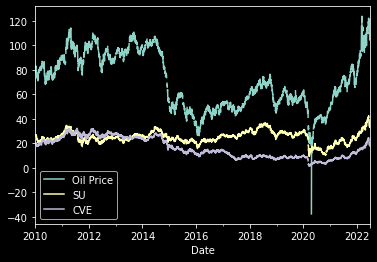

In [77]:
oil_hist = get_hist('CL=F')
su_hist = get_hist('SU')
cve_hist = get_hist('CVE')
pd.concat([oil_hist['Close'].rename('Oil Price'), su_hist['Close'].rename('SU'), cve_hist['Close'].rename('CVE')], axis=1).loc['2010':, :].plot()